In [70]:
import tensorflow as tf
import tensorflow_datasets as tfds

Downloading and Preprocessing the data

In [71]:
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [72]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [73]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [74]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image, label

In [75]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [76]:
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [77]:
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [78]:
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [79]:
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [80]:
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

Creating the Model and Training it

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

In [82]:
model.summary(line_length = 75)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)              │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_8 (MaxPooling2D) │ (None, 12, 12, 50)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_9 (Conv2D)              │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_9 (MaxPooling2D) │ (None, 5, 5, 50)        │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten_4 (Flatten)            │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense_4 (Dense)                │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [84]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [85]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

In [86]:
model.fit(
    train_data,
    epochs = NUM_EPOCHS,
    callbacks = [early_stopping],
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 7s - 16ms/step - accuracy: 0.9247 - loss: 0.2676 - val_accuracy: 0.9773 - val_loss: 0.0786
Epoch 2/20
422/422 - 6s - 14ms/step - accuracy: 0.9788 - loss: 0.0705 - val_accuracy: 0.9852 - val_loss: 0.0516
Epoch 3/20
422/422 - 6s - 14ms/step - accuracy: 0.9840 - loss: 0.0518 - val_accuracy: 0.9848 - val_loss: 0.0539
Epoch 4/20
422/422 - 6s - 14ms/step - accuracy: 0.9869 - loss: 0.0419 - val_accuracy: 0.9888 - val_loss: 0.0352
Epoch 5/20
422/422 - 6s - 13ms/step - accuracy: 0.9893 - loss: 0.0352 - val_accuracy: 0.9880 - val_loss: 0.0397
Epoch 6/20
422/422 - 6s - 14ms/step - accuracy: 0.9898 - loss: 0.0324 - val_accuracy: 0.9923 - val_loss: 0.0265
Epoch 7/20
422/422 - 6s - 14ms/step - accuracy: 0.9918 - loss: 0.0267 - val_accuracy: 0.9958 - val_loss: 0.0147
Epoch 8/20
422/422 - 6s - 14ms/step - accuracy: 0.9924 - loss: 0.0241 - val_accuracy: 0.9928 - val_loss: 0.0210
Epoch 9/20
422/422 - 6s - 13ms/step - accuracy: 0.9938 - loss: 0.0200 - val_accuracy: 0.9955 - val_loss:

Testing Our Model

In [87]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - accuracy: 0.9897 - loss: 0.0322


In [88]:
# Printing the test results
print('Test loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss, test_accuracy*100))

Test loss:  0.0322. Test accuracy:  98.97%


Ploting Images and the results

In [90]:
import matplotlib.pyplot as plt
import numpy as np

In [92]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

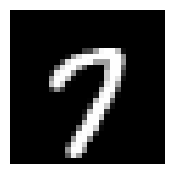

label: 7


In [113]:
# The image to be displayed and tested
i = 5054

# plot the image
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="grey", aspect='auto')
plt.show()

# print the correct label for the image
print("label: {}".format(labels_test[i-1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<BarContainer object of 10 artists>

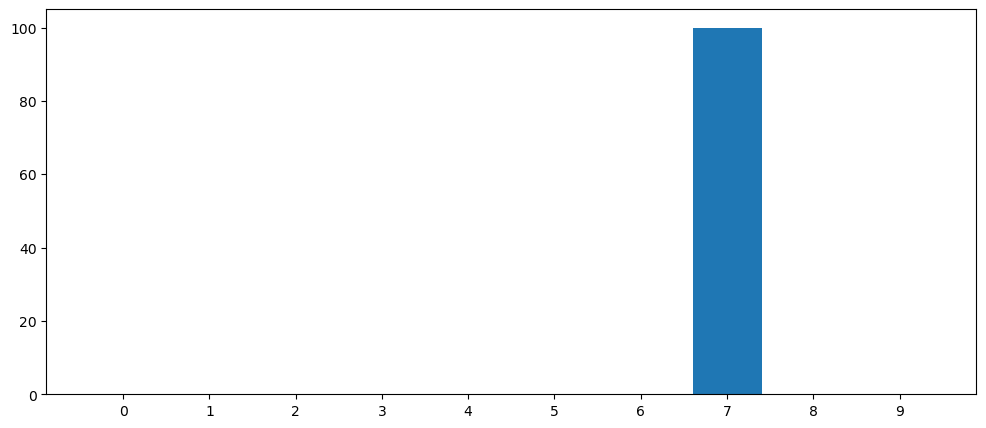

In [114]:
# obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmax activities into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities * 100

# create a bar chart to plot the probabilites for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10],height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])